# Segmentation of Figure 8

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import io, color, filters, measure, morphology, segmentation
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output
import warnings
warnings.filterwarnings('ignore')

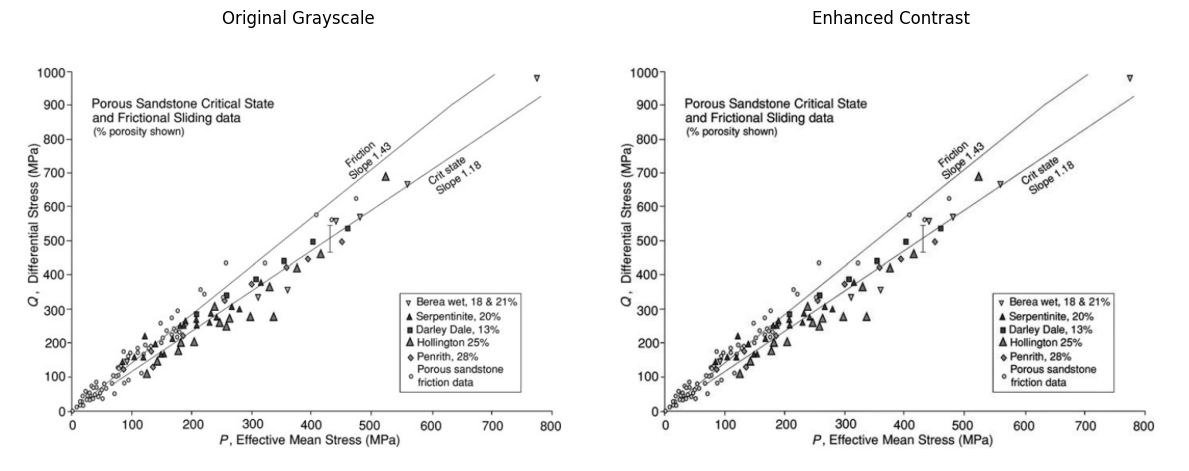

In [2]:
# Load Figure 8 graph
image = cv2.imread('figure/fig8.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
enhanced_grayscale = clahe.apply(grayscale_image)

# Display original and enhanced images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(grayscale_image, cmap='gray')
ax1.set_title('Original Grayscale')
ax1.axis('off')

ax2.imshow(enhanced_grayscale, cmap='gray')
ax2.set_title('Enhanced Contrast')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Use the enhanced image for further processing
grayscale_image = enhanced_grayscale

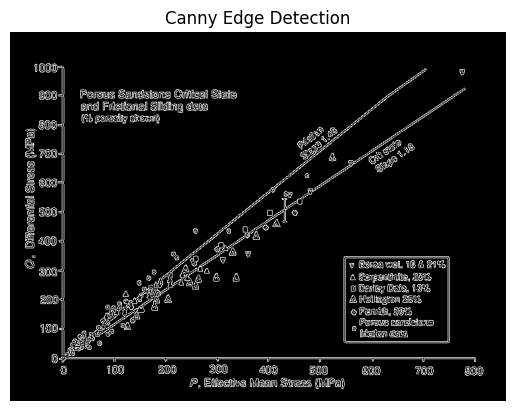

In [3]:
# Edge detection using Canny method
edges = cv2.Canny(grayscale_image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

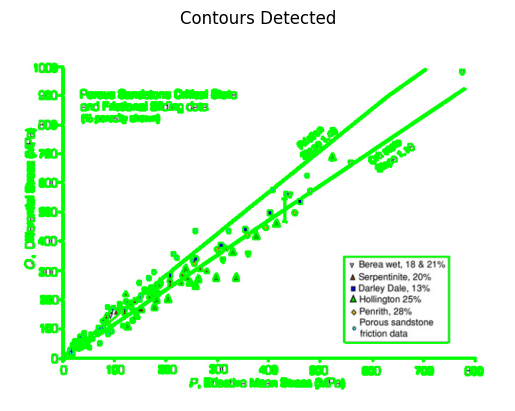

In [4]:
# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours on the original image
contour_image = image.copy()
for contour in contours:
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
plt.imshow(contour_image)
plt.title('Contours Detected')
plt.axis('off')
plt.show()

In [5]:
# Calculate areas of all contours
areas = [cv2.contourArea(c) for c in contours]
# print the areas of the contours
print(f"Number of contours: {len(areas)}")
print(f"Min area: {min(areas) if areas else 0}")
print(f"Max area: {max(areas) if areas else 0}")
print(f"Mean area: {np.mean(areas) if areas else 0}")
print(f"Median area: {np.median(areas) if areas else 0}")

Number of contours: 300
Min area: 0.0
Max area: 20663.5
Mean area: 108.54666666666667
Median area: 11.5


In [6]:
# Pair each contour with its area
contour_area_pairs = list(zip(contours, areas))
# Sort by area, descending
contour_area_pairs.sort(key=lambda x: x[1], reverse=True)

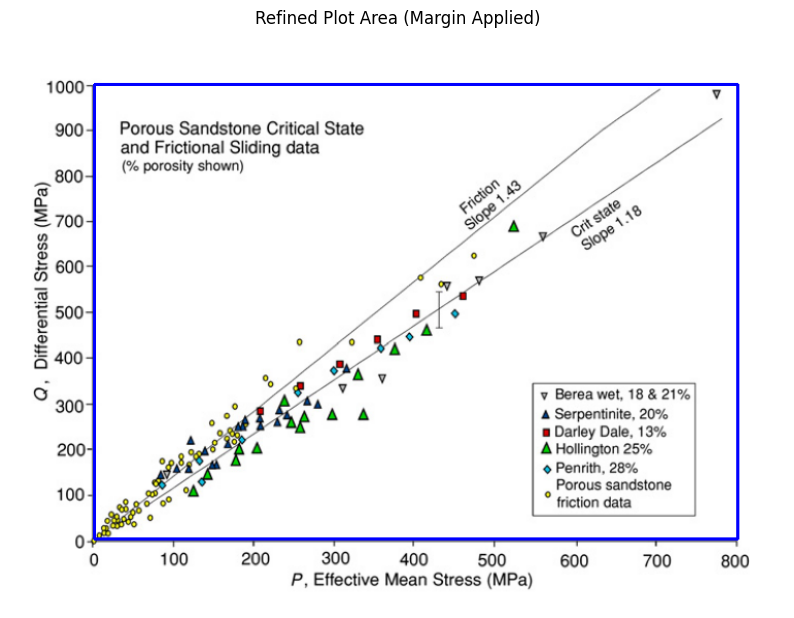

In [7]:
# Identifying the Plot Area
# Use Canny edge detection
edges = cv2.Canny(grayscale_image, 50, 150)

margin = 15  # You can adjust this value as needed

# Use Hough Line Transform to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Find the extreme lines (leftmost, rightmost, topmost, bottommost)
x_min, x_max, y_min, y_max = image.shape[1], 0, image.shape[0], 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_min = min(x_min, x1, x2)
    x_max = max(x_max, x1, x2)
    y_min = min(y_min, y1, y2)
    y_max = max(y_max, y1, y2)

# Refine the bounding box: move left and bottom sides inward by margin
plot_left   = min(x_min + margin + 3, image.shape[1] - 1)
plot_right  = max(x_max, 0)
plot_top    = min(y_min, image.shape[0] - 1)
plot_bottom = max(y_max - margin - 30, 0)

# Ensure coordinates are within image bounds
plot_left   = max(plot_left, 0)
plot_right  = min(plot_right, image.shape[1] - 1)
plot_top    = max(plot_top, 0)
plot_bottom = min(plot_bottom, image.shape[0] - 1)

# Draw the refined plot area
plot_area_img = image.copy()
cv2.rectangle(plot_area_img, (plot_left, plot_top), (plot_right, plot_bottom), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_area_img, cv2.COLOR_BGR2RGB))
plt.title('Refined Plot Area (Margin Applied)')
plt.axis('off')
plt.show()

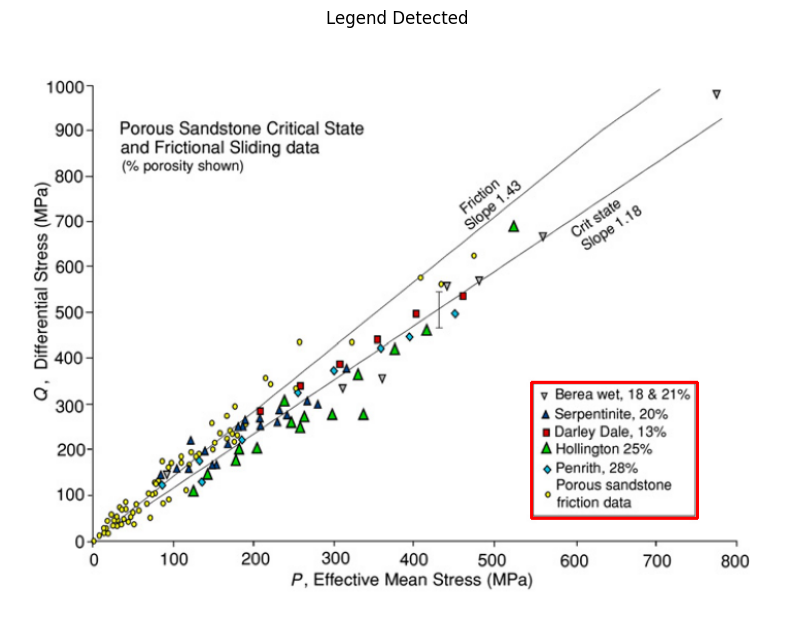

In [8]:
# Identifying the Legend Area
legend_candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0
    # Heuristic: legend is in the right 1/3 and lower 1/2 of the image, and is a medium-large box
    if (x > image.shape[1] * 0.6 and y > image.shape[0] * 0.5 and
        area > 1000 and area < 0.2 * image.shape[0] * image.shape[1] and
        0.7 < aspect_ratio < 2.5):
        legend_candidates.append((x, y, w, h))

# Draw the legend box
legend_img = image.copy()
for (x, y, w, h) in legend_candidates:
    cv2.rectangle(legend_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
plt.title('Legend Detected')
plt.axis('off')
plt.show()

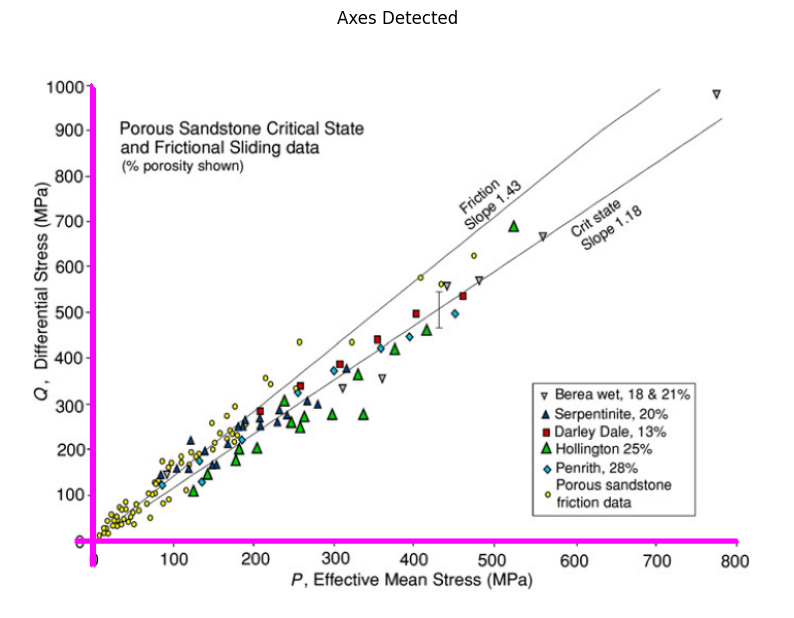

In [9]:
# Identifying the Axes
axes_img = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Vertical (y-axis)
    if abs(x1 - x2) < 10 and abs(y1 - y2) > image.shape[0] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)
    # Horizontal (x-axis)
    if abs(y1 - y2) < 10 and abs(x1 - x2) > image.shape[1] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(axes_img, cv2.COLOR_BGR2RGB))
plt.title('Axes Detected')
plt.axis('off')
plt.show()

## Extract Text from Plot Regions
Extract text from title, legend, and axes scales & labels using OCR

## Extract Axes Information
Extract scales and titles from the detected axes regions

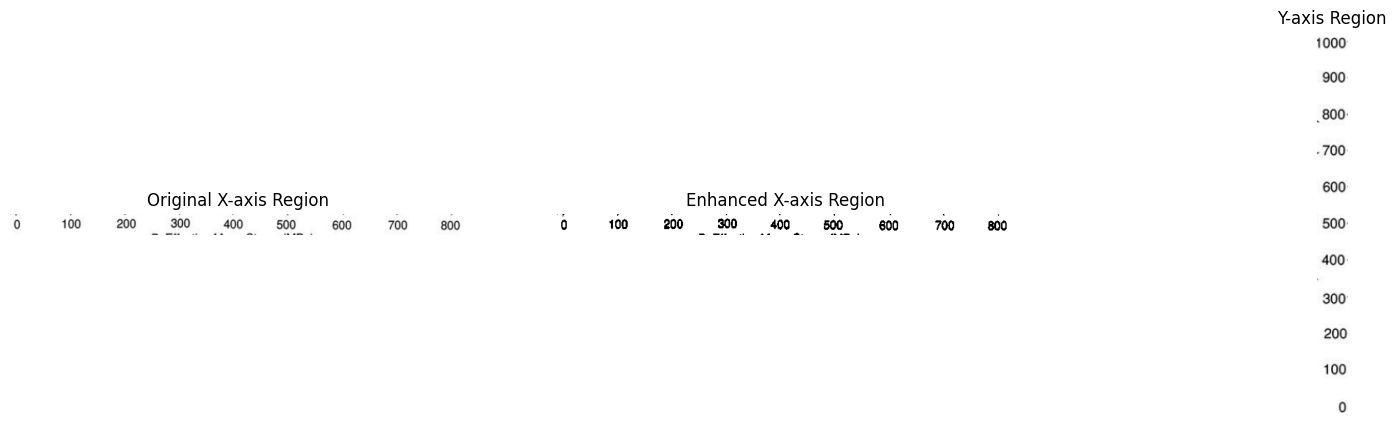

In [13]:
# Extract x-axis scale region with adjusted boundaries
x_scale_region = grayscale_image[plot_bottom+5:plot_bottom+35, plot_left-10:plot_right+20]

# Enhance x-axis scale visibility
x_scale_enhanced = cv2.threshold(
    x_scale_region, 
    0, 255, 
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)[1]

# Dilate text slightly to separate digits
kernel = np.ones((2,1), np.uint8)
x_scale_enhanced = cv2.erode(x_scale_enhanced, kernel, iterations=1)

# Extract y-axis scale region with adjusted boundaries
y_scale_region = grayscale_image[plot_top-10:plot_bottom+15, max(0, plot_left-44):plot_left-7]

# Visualize the extracted and preprocessed regions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(x_scale_region, cmap='gray')
ax1.set_title('Original X-axis Region')
ax1.axis('off')

ax2.imshow(x_scale_enhanced, cmap='gray')
ax2.set_title('Enhanced X-axis Region')
ax2.axis('off')

ax3.imshow(y_scale_region, cmap='gray')
ax3.set_title('Y-axis Region')
ax3.axis('off')
plt.show()

In [ ]:
def process_x_axis_text(text):
    # Split by any non-digit character
    import re
    # First clean up the text
    text = text.replace('\n', ' ').strip()
    # Find all number sequences
    numbers = re.findall(r'\d+', text)
    # Convert to integers and filter valid range
    values = []
    expected_values = [0, 100, 200, 300, 400, 500, 600, 700, 800]  # Expected x-axis values
    
    for num in numbers:
        try:
            value = int(num)
            # Only accept values that are close to expected values
            if any(abs(value - expected) < 50 for expected in expected_values):
                values.append(value)
        except ValueError:
            continue
    
    return sorted(list(set(values)))  # Remove duplicates and sort

# Extract text from scale regions with specific OCR configuration
x_scale_text = pytesseract.image_to_string(
    x_scale_enhanced,  # Use the enhanced image
    config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789 '
)

y_scale_text = pytesseract.image_to_string(
    y_scale_region,
    config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789.-'
)

# Process the text to extract values
x_values = process_x_axis_text(x_scale_text)
y_values = sorted([float(n) for n in y_scale_text.split() if n.strip()], reverse=True)

print('X-axis values:', x_values)
print('Y-axis values:', y_values)

# Debug output
print('\nRaw X-axis text:', repr(x_scale_text))

X-axis values: [0.0]
Y-axis values: [1000.0, 900.0, 800.0, 700.0, 600.0, 500.0, 400.0, 300.0, 200.0, 100.0, 0.0]

Raw X-axis text: '0 10020043004004450046004700800\n'


In [12]:
# Extract axes titles from label candidates
axes_titles = {'x': None, 'y': None}

for label_type, x, y, w, h in label_candidates:
    # Extract and process the region
    if label_type == 'X Label':
        x_title_region = grayscale_image[y:y+h, x:x+w]
        x_title_enhanced = cv2.equalizeHist(x_title_region)
        axes_titles['x'] = pytesseract.image_to_string(x_title_enhanced).strip()
    elif label_type == 'Y Label':
        y_title_region = grayscale_image[y:y+h, x:x+w]
        y_title_enhanced = cv2.equalizeHist(y_title_region)
        axes_titles['y'] = pytesseract.image_to_string(y_title_enhanced).strip()

print('X-axis title:', axes_titles['x'])
print('Y-axis title:', axes_titles['y'])

NameError: name 'label_candidates' is not defined

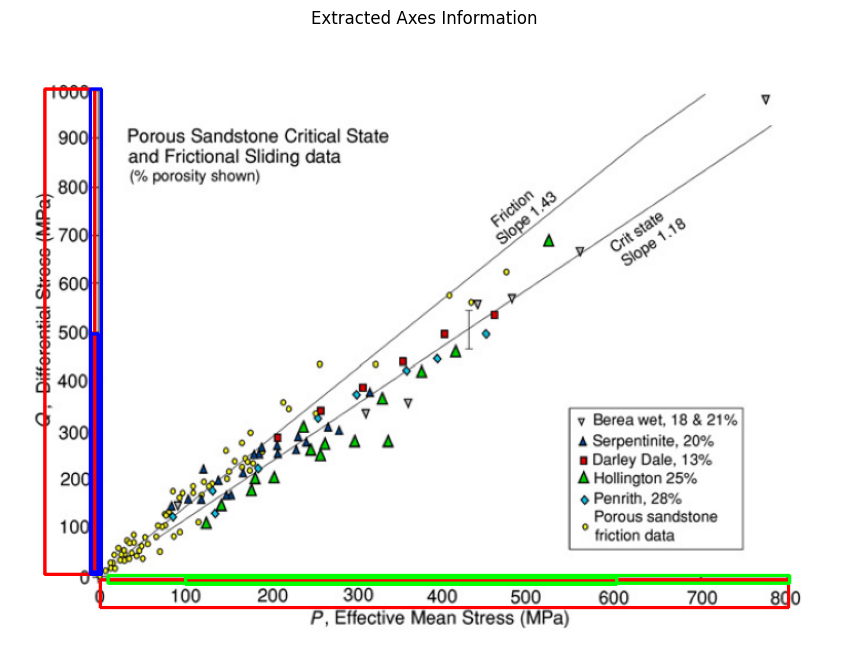

In [ ]:
# Visualize the extracted information on the original image
vis_img = image_rgb.copy()

# Draw rectangles around adjusted scale regions
cv2.rectangle(vis_img, 
            (plot_left-5, plot_bottom+5), 
            (plot_right+10, plot_bottom+35), 
            (255, 0, 0), 2)
cv2.rectangle(vis_img, 
            (max(0, plot_left-50), plot_top-10), 
            (plot_left-5, plot_bottom), 
            (255, 0, 0), 2)

# Draw rectangles around axis titles
for label_type, x, y, w, h in label_candidates:
    color = (0, 255, 0) if label_type == 'X Label' else (0, 0, 255)
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(vis_img)
plt.title('Extracted Axes Information (Adjusted)')
plt.axis('off')
plt.show()